# 项目背景介绍

该项目创作初衷是为了整理日常生活中从各个渠道得到的二次元图片，在保存图片的过程中，常常会掺杂一些其他图片例如风景照、截图、表情包等等。  
为了免去手动挑选图片的烦恼，我使用了PaddleX框架训练了一个可以分类二次元图片的模型

# PaddleX介绍

PaddleX是飞桨提供的全流程开发工具。它集飞桨核心框架、模型库、工具及组件等深度学习开发所需全部能力于一身，将智能视觉领域的四大任务：图像分类、目标检测、语义分割、实例分割的数据读取、数据增强、超参配置、训练评估等进行模块化抽象，并全流程打通，并提供**简明易懂的Python API**，方便用户根据实际生产需求进行直接调用或二次开发。

考虑产业实践的真实诉求，飞桨团队还为大家实现了一个**基于PaddleX开发的可视化前端界面**，提供Windows、Linux、Mac系统的一键安装包，让大家可以快速领略PaddleX可以为产业带来的效用。大家还可以基于PaddleX开发各种各样满足自己需求的产品。  

***PaddleX项目地址***：[https://github.com/PaddlePaddle/PaddleX](https://github.com/PaddlePaddle/PaddleX)  
***PaddleX文档链接***：[https://paddlex.readthedocs.io](https://paddlex.readthedocs.io)   
***PaddleX可视化模型训练客户端下载***：[https://www.paddlepaddle.org.cn/paddle/paddlex](https://www.paddlepaddle.org.cn/paddle/paddlex)  
***PaddleX用户QQ群***: 1045148026  

# 数据集介绍

训练的数据集是我自己简单制作的，包含的图片并不全面，大家可以根据自己需求自己制作数据集  


数据集图片分为两类：二次元图片和非二次元图片一共有3000多张图片  
大概是这个样子的  

![](https://ai-studio-static-online.cdn.bcebos.com/c5abb8c1c46844848c616e4e5162d3d4642974f9a80f4153a672e4740dba9346)![](https://ai-studio-static-online.cdn.bcebos.com/e6088b98030f4146a8f1d604480e17da51da00113a3f44438412f618c5c263d5)

# ResNet

### 本项目使用ResNet网络结构  
![](https://ai-studio-static-online.cdn.bcebos.com/fa3302001cdb416c953a658fad48712eb90d6867df834981b860499d3fa4e068)  
ResNet(Residual Network)是2015年ImageNet图像分类、图像物体定位和图像物体检测比赛的冠军。针对随着网络训练加深导致准确度下降的问题，ResNet提出了残差学习方法来减轻训练深层网络的困难。在已有设计思路(BN, 小卷积核，全卷积网络)的基础上，引入了残差模块。每个残差模块包含两条路径，其中一条路径是输入特征的直连通路，另一条路径对该特征做两到三次卷积操作得到该特征的残差，最后再将两条路径上的特征相加。


# 下面是数据处理和训练过程

## [0] 安装PaddleX

In [1]:
!pip install paddlex
# 每次启动都要重新运行

## [1] 导入依赖模块

In [2]:
import warnings
warnings.filterwarnings('ignore') # 忽略警告信息

import os
import re
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 设置环境变量

from paddlex import transforms as T # 用于定义模型训练、验证、预测过程中，输入图像的预处理和数据增强操作
                                    
import paddlex as pdx
import paddle

import numpy as np
import pandas as pd
import shutil # 文件文档处理库
import cv2    
import imghdr # 检测图片类型
from PIL import Image # 常用图片处理库

## [2] 生成ImageNet格式文件夹

### [2.1] 解压数据集,生成类别文件夹

因为中文文件名所以解压出来是乱码，大家做数据集时候起个英文名字

In [3]:
pdx.utils.decompress('data/data128010/二次元分类数据集.zip')

2022-02-21 23:15:50 [INFO]	Decompressing data/data128010/äºæ¬¡ååç±»æ°æ®é.zip...


'data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»'

In [4]:
!rm -rf data/data128010/ImageNetDataset # 删除文件夹，防止多次运行时出错
for i in range(2):
    cls_path = os.path.join('data/data128010/ImageNetDataset/', '%02d' % int(i)) # 拼接路径
    if not os.path.exists(cls_path):
        os.makedirs(cls_path) # 创建文件夹

In [ ]:
!ls data/data128010/ImageNetDataset # 列出文件夹

00  01


### [2.2] 转换统一格式


In [5]:
path="data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»"
file_walk = os.walk(path)
fileNum = 0
filesPathList = []
for root, dirs, files in file_walk:
    for file in files:
        fileNum = fileNum + 1
        filePath = root + '/' + file
        # print(filePath)
        filesPathList.append(filePath)
        protion = os.path.splitext(filePath)
        # print(protion[0],protion[1])

        if protion[1].lower() == '.png' or protion[1].lower() == '.jpeg' or protion[1].lower() == '.JPG':
            print("正在处理：" + filePath)
            newFilePath = protion[0] + '.jpg'
            os.rename(filePath, newFilePath)

### [2.3] 生成对应标签

In [6]:
# 重命名
num = 1
def file_name(file_dir,num):
    for root, dirs, files in os.walk(file_dir): 
        # print(root) #当前目录路径 
        # print("+++++++++++++++++++++++++++++++++++++")
        # print(dirs) #当前路径下所有子目录 
        # print("**************************************")
        # print(files) #当前路径下所有非目录子文件
        for i in range(len(files)):
            print(i)
            # NewFile=files[i].replace(" ","")
            NewFile = os.path.join(file_dir, '%05d' % int(num) + '.jpg')
            print(NewFile)
            try:
                os.rename(file_dir+files[i],NewFile)
            except Exception as e:
                print(e)
                print('rename file fail\r\n')
            else:
                print('rename file success\r\n')
            num=num+1
        print("#########################################")
        
file_name(r"data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/0/",num)
file_name(r"data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/1/",num)


In [7]:
import glob

path = 'data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/'

# 制作标签文件
def generate_train_and_val(image_path, txt_file):
    with open(txt_file, 'w') as tf:
        for jpg_file in glob.glob(image_path + '*.jpg'):
            tf.write(jpg_file + '\t' + '0' '\n')

generate_train_and_val(path + '0/', path + 'train_list.txt')

def generate_train_and_val(image_path, txt_file):
    with open(txt_file, 'a') as tf:
        for jpg_file in glob.glob(image_path + '*.jpg'):
            tf.write(jpg_file + '\t' + '1' '\n')

generate_train_and_val(path + '1/', path + 'train_list.txt')

### [2.4] 异常格式的数据清洗

In [8]:
train_df = pd.read_csv('data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/train_list.txt', header=None, sep='\t') # 读取测试集标签
train_df.columns = ['name', 'cls'] # 返回列索引列表
train_df['name'] = train_df['name'].apply(lambda x: str(x).strip().split('/')[-1]) # 切分文件名
train_df['cls'] = train_df['cls'].apply(lambda x: '%02d' % int(str(x).strip())) # 使图片标签类别变成2位数字
train_df.head() # 观察前五行数据格式

,name,cls
0,01441.jpg,00
1,01472.jpg,00
2,00429.jpg,00
3,00198.jpg,00
4,01338.jpg,00


In [9]:
for i in range(len(train_df)):
    img_path = os.path.join('data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/0', train_df.at[i, 'name']) # i 元素在列中的位置 ，name 列名
    if os.path.exists(img_path) and imghdr.what(img_path): # 检测路径文件是否存在及判断类别
        img = Image.open(img_path) # 打开文件
        if img.mode != 'RGB':
            img = img.convert('RGB') # 转换成rgb形式
            img.save(img_path) # 保存
          
for i in range(len(train_df)):
    img_path = os.path.join('data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/1', train_df.at[i, 'name']) # i 元素在列中的位置 ，name 列名
    if os.path.exists(img_path) and imghdr.what(img_path): # 检测路径文件是否存在及判断类别
        img = Image.open(img_path) # 打开文件
        if img.mode != 'RGB':
            img = img.convert('RGB') # 转换成rgb形式
            img.save(img_path) # 保存


**从源路径 src_path 移动至目标路径 dst_path。**

In [10]:
src_path1 = 'data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/0/'
dst_path1 = 'data/data128010/ImageNetDataset/00'
src_path2 = 'data/data128010/╢■┤╬╘¬╖╓└α╩²╛▌╝»/1/'
dst_path2 = 'data/data128010/ImageNetDataset/01'
for dirpath, dirnames, filenames in os.walk((src_path1)):
    for filename in filenames:
        try:
            shutil.move(src_path1+filename, dst_path1) # 移动图片到目标路径
        except Exception as e:
            print(e) # 抛出错误信息

for dirpath, dirnames, filenames in os.walk((src_path2)):
    for filename in filenames:
        try:
            shutil.move(src_path2+filename, dst_path2) # 移动图片到目标路径
        except Exception as e:
            print(e) # 抛出错误信息


## [3] 数据集划分

In [11]:
!paddlex --split_dataset --format ImageNet\
    --dataset_dir data/data128010/ImageNetDataset\
    --val_value 0.10\
    --test_value 0

[02-21 23:16:49 MainThread @logger.py:242] Argv: /opt/conda/envs/python35-paddle120-env/bin/paddlex --split_dataset --format ImageNet --dataset_dir data/data128010/ImageNetDataset --val_value 0.10 --test_value 0
[02-21 23:16:49 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/

## [4] 定义数据增强、装载数据集

In [12]:
# 训练集增强
train_transforms = T.Compose([
    T.MixupImage(
        alpha=1.5,
        beta=1.5,
        mixup_epoch=int(100)),
    T.Resize(
        target_size=410,
        interp='RANDOM'),
    # 以一定的概率对图像进行随机水平翻转
    T.RandomHorizontalFlip(0.5),
    # 以一定的概率对图像进行随机像素内容变换，可包括亮度、对比度、饱和度、色相角度、通道顺序的调整，模型训练时的数据增强操作
    T.RandomDistort(
        brightness_range=0.25,
        brightness_prob=0.5,
        contrast_range=0.25,
        contrast_prob=0.5,
        saturation_range=0.25,
        saturation_prob=0.5,
        hue_range=18.0,
        hue_prob=0.5),
    # 以一定的概率对图像进行高斯模糊
    T.RandomBlur(0.2),
    # 对图像进行标准化
    T.Normalize()
])
# 验证集增强
eval_transforms = T.Compose([
    T.Resize(
        target_size=410,
        interp='AREA'),
    T.Normalize()
])

In [13]:
# 装载数据集
train_dataset = pdx.datasets.ImageNet(
    data_dir='data/data128010/ImageNetDataset',
    file_list='data/data128010/ImageNetDataset/train_list.txt',
    label_list='data/data128010/ImageNetDataset/labels.txt',
    transforms=train_transforms,
    shuffle=True) # 是否需要对数据集中样本打乱顺序

eval_dataset = pdx.datasets.ImageNet(
    data_dir='data/data128010/ImageNetDataset',
    file_list='data/data128010/ImageNetDataset/val_list.txt',
    label_list='data/data128010/ImageNetDataset/labels.txt',
    transforms=eval_transforms)

2022-02-21 23:17:12 [INFO]	Starting to read file list from dataset...
2022-02-21 23:17:12 [INFO]	3471 samples in file data/data128010/ImageNetDataset/train_list.txt
2022-02-21 23:17:12 [INFO]	Starting to read file list from dataset...
2022-02-21 23:17:12 [INFO]	385 samples in file data/data128010/ImageNetDataset/val_list.txt


## 查看数据集

In [ ]:
print(len(train_dataset))
print(train_dataset[0])


1390
{'image': array([[[-0.42111814, -0.29957   , -0.08207586],
        [-0.3948114 , -0.27265304, -0.05537232],
        [-0.36850467, -0.24573597, -0.02866891],
        ...,
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ]],

       [[-0.42111814, -0.29957   , -0.08207586],
        [-0.3948114 , -0.27265304, -0.05537232],
        [-0.36850467, -0.24573597, -0.02866891],
        ...,
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ]],

       [[-0.42111814, -0.29957   , -0.08207586],
        [-0.3948114 , -0.27265304, -0.05537232],
        [-0.36850467, -0.24573597, -0.02866891],
        ...,
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ],
        [-1.2366276 , -1.1339959 , -0.9098808 ]],

       ...,

       [[-2.117904  , -2.0357141 , -1.8044444

In [ ]:
# 查看路径下文件
!tree data/data128010/ImageNetDataset

## 展示数据集图片样例

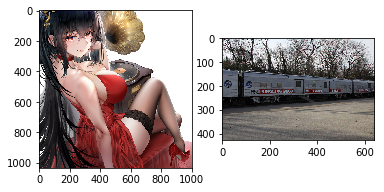

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img1 = Image.open('data/data128010/ImageNetDataset/00/00659.jpg')
img2 = Image.open('data/data128010/ImageNetDataset/01/00959.jpg')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

## [5] 配置 ResNet 模型并训练

In [14]:
#初始化模型
model = pdx.cls.ResNet101_vd_ssld(
    num_classes=len(train_dataset.labels)
)

W0221 23:17:33.864406   101 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0221 23:17:33.869711   101 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [15]:
model.train(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    num_epochs=300, #训练轮数
    train_batch_size=16, #一个step所用到的样本量
    warmup_steps=(len(train_dataset.file_list) // 32) * 6, #学习率从0经过steps轮迭代增长到设定的学习率
    learning_rate=0.0125, # 学习率
    lr_decay_epochs=[40, 100, 160, 205], #表示学习率在第几个epoch时衰减一次
    lr_decay_gamma=0.1, # 学习率衰减率

    save_interval_epochs=2, # 每几轮保存一次
    log_interval_steps=(len(train_dataset.file_list) // 32) * 7, # 训练日志输出间隔

    pretrain_weights='IMAGENET',
    #pretrain_weights (str or None): 若指定为'.pdparams'文件时，则从文件加载模型权重；
    #若为字符串'IMAGENET'，则自动下载在ImageNet图片数据上预训练的模型权重；
    #若为None，则不使用预训练模型。默认为'IMAGENET'
    save_dir='output/ResNet101_vd_ssld',
    use_vdl=False)

## [6] 模型预测

In [43]:
model = pdx.load_model('output/ResNet101_vd_ssld/epoch_40') # 加载模型
model.get_model_info() # 显示信息

2022-02-17 19:50:27 [INFO]	Model[ResNet101_vd_ssld] loaded.


{'version': '2.1.0',
 'Model': 'ResNet101_vd_ssld',
 '_Attributes': {'model_type': 'classifier',
  'num_classes': 2,
  'labels': ['00', '01'],
  'fixed_input_shape': None,
  'eval_metrics': {'acc1': 0.9975961446762085}},
 '_init_params': {'num_classes': 2},
 'Transforms': [{'Resize': {'target_size': (410, 410),
    'interp': 'AREA',
    'keep_ratio': False}},
  {'Normalize': {'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'min_val': [0, 0, 0],
    'max_val': [255.0, 255.0, 255.0],
    'is_scale': True}}],
 'completed_epochs': 0}

In [44]:
import glob

test_list = glob.glob('work/test/*.jpg')
test_df = pd.DataFrame() # 创建表结构

for i in range(len(test_list)):
    img = Image.open(test_list[i]).convert('RGB')
    img = np.asarray(img, dtype='float32') # 转换数据类型

    result = model.predict(img[:, :, [2, 1, 0]]) # 预测结果
    test_df.at[i, 'name'] = str(test_list[i]).split('/')[-1] # 文件名
    test_df.at[i, 'cls'] = int(result[0]['category_id']) # 类别

print(test_df)


                                   name  cls
0  9127EC55A4C78D808956928181F0921B.jpg  1.0
1  8F0624DA275EB7124F60745654DE4EDE.jpg  1.0
2                QQ图片20211204191309.jpg  0.0
3                QQ图片20220131232140.jpg  0.0
4  F2B0B13216C2DF389CC544B270163CF1.jpg  1.0
5                QQ图片20220216193812.jpg  0.0
6                QQ图片20210907150200.jpg  0.0


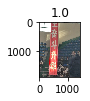

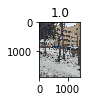

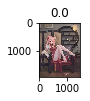

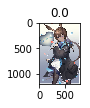

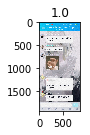

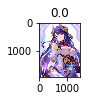

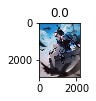

In [40]:
path = 'work/test'
list1 = []
for i in range(len(test_df)):   
    img_path = os.path.join(path, test_df.at[i, 'name']) # i 元素在列中的位置 ，name 列名
    list1.append(img_path)

for i in range(len(test_df)): 
    plt.figure().add_subplot(1,len(test_df),i+1)
    img = Image.open(list1[i])
    plt.title(test_df.at[i,'cls'])
    plt.imshow(img)
plt.show(block = True)


In [16]:
# 保存模型（换个文件夹）
!mkdir -p work/ResNet101_vd_ssld/
!cp -rp output/ResNet101_vd_ssld/epoch_40 work/ResNet101_vd_ssld/epoch_300

# 使用模型进行分类

In [ ]:
scr_path = '要分类的图片目录' # 源目录
dst_path = '目标目录' # 目标目录

model = pdx.load_model('模型路径') # 加载模型
# print(model.get_model_info())# 显示信息

import glob

test_list = glob.glob(scr_path+'/*')
test_df = pd.DataFrame() # 创建表结构
# 将所有图片装进表中
for i in range(len(test_list)):
    img = Image.open(test_list[i]).convert('RGB')
    img = np.asarray(img, dtype='float32') # 转换数据类型

    result = model.predict(img[:, :, [2, 1, 0]]) # 预测结果
    test_df.at[i, 'name'] = str(test_list[i]).split('/')[-1] # 文件名
    test_df.at[i, 'cls'] = int(result[0]['category_id']) # 类别

print(test_df)

# 移动图片进行分类
for i in range(len(test_df)):
    img_path = os.path.join(scr_path, test_df.at[i, 'name']) # i 元素在列中的位置 ，name 列名
    save_path = os.path.join(dst_path, str(test_df.at[i, 'cls']))

    if not os.path.exists(save_path):
        os.makedirs(save_path)  # 没有则创建文件夹

    try:
        shutil.move(img_path, save_path)  # 移动图片到目标路径
    except Exception as e:
        print(e)  # 抛出错误信息

# 项目总结

这个项目最初的设想想是能将各种类型的图片单独分类，但是由于时间原因和数据集的制作没有实现最初的设想，只能简单的二分类，大家可以在此基础上加以改进达到自己想要的目的